# CLPsych Classification NLP Project
Noel Ellison

## 1. Set-up Data and Packages

### 1.1 Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#BERT model imports
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'
print(torch.version.cuda)

device


12.1


'cuda'

Helpful website for understanding XML data structures: https://nanonets.com/blog/parse-xml-files-using-python/#:~:text=Let's%20start%20by%20importing%20the,root%20tag%20as%20shown%20below.


Turn the XML files into a pandas DF: https://www.reddit.com/r/learnpython/comments/zh9vgw/parsing_xml_into_a_pandas_dataframe/

https://stackabuse.com/reading-and-writing-xml-files-in-python-with-pandas/

### 1.2 Read-in Source Data

#### 1.2.1 Read-in XML Files (individual posts)

In [3]:
#This code checks one XML file
from os import listdir, path
import xml.etree.ElementTree as ET
import re
import os
from lxml import etree

mypath = 'I:/Project/clpsych17-data/clpsych17-data/data/training/posts/post-886.xml'
#files = [path.join(mypath, f) for f in listdir(mypath) if f.endswith('.xml')]
messageIDs = []
messageBodys = []
messagePostTimes = []
authorIDs = []


tree = ET.parse(mypath)
root = tree.getroot()
for x in root[0]:
    print(x.tag, x.attrib)
    if x.tag == 'kudos':
            print(x.findall(".//count")[0].text)
    if x.tag == 'views':
            print(x.findall(".//count")[0].text)

board_id {'type': 'int'}
root {'type': 'message', 'href': '/messages/id/52'}
kudos {}
0
message_rating {'type': 'float'}
last_edit_author {'type': 'user', 'href': '/users/id/68'}
post_time {'type': 'date_time'}
last_edit_time {'type': 'date_time'}
body {'type': 'string'}
thread {'type': 'thread', 'href': '/threads/id/52'}
board {'type': 'board', 'href': '/boards/id/Games'}
parent {'type': 'message', 'href': '/messages/id/856'}
teaser {'type': 'string'}
views {}
2094
subject {'type': 'string'}
id {'type': 'int'}
read_only {'type': 'boolean'}
deleted {'type': 'boolean'}
author {'type': 'user', 'href': '/users/id/68'}


In [4]:
#Import all XML data which contains the text of the posts
from os import listdir, path
import xml.etree.ElementTree as ET
import re
import os
from lxml import etree

mypath = 'I:/Project/clpsych17-data/clpsych17-data/data/training/posts'
files = [path.join(mypath, f) for f in listdir(mypath) if f.endswith('.xml')]
messageIDs = []
messageBodys = []
messagePostTimes = []
authorIDs = []
kudos = []
views = []

#for file in files:
 #   print(file)
  #  tree = ET.parse(file)
   # root = tree.getroot()
    #for x in root[0]:
     #   print(x.tag, x.attrib)

for file in files:
    res = re.findall("post-(\d+).xml", file)
    if not res: continue
    messageIDs.append(res[0]) # You can append the result to a list
    tree = ET.parse(file)
    root = tree.getroot()
    for x in root[0]:
    #print(x.tag, x.attrib)
        if x.tag == 'body':
            messageBodys.append(x.text)
        if x.tag == 'post_time':
            messagePostTimes.append(x.text)
        if x.tag == 'author':
            authorIDs.append((x.attrib['href']).replace('/users/id/',''))
        if x.tag == 'kudos':
            kudos.append(x.findall(".//count")[0].text)
        if x.tag == 'views':
            views.append(x.findall(".//count")[0].text)
    if len(messageBodys) != len(messageIDs):
        messageBodys.append('')
    if len(messagePostTimes) != len(messageIDs):
        messagePostTimes.append('')
    if len(authorIDs) != len(messageIDs):
        authorIDs.append('')
    if len(kudos) != len(messageIDs):
        authorIDs.append('')
    if len(views) != len(messageIDs):
        authorIDs.append('')
    #print(res[0])


#tree.find('./message type').attrib['key']


In [5]:
print(len(messageIDs))
print(len(authorIDs))
print(len(messageBodys))
print(len(views))
print(len(kudos))
print(len(messagePostTimes))

65755
65755
65755
65755
65755
65755


In [7]:
import pandas as pd
dict = {'Message ID': messageIDs,'Author ID': authorIDs, 'Message Body': messageBodys, 'Message Views': views, 'Message Kudos': kudos, 'Message Post Time': messagePostTimes} 
    
df = pd.DataFrame(dict)

In [8]:
df.tail()

,Message ID,Author ID,Message Body,Message Views,Message Kudos,Message Post Time
65750,99987,3030,"<P>Hey <a href=""http://forums.au.reachout.com/...",451,0,2014-08-22T10:28:17+00:00
65751,99989,292,"<P><a href=""http://forums.au.reachout.com/t5/u...",745,0,2014-08-22T10:29:15+00:00
65752,99993,3030,"<P>Hey <a href=""http://forums.au.reachout.com/...",489,1,2014-08-22T10:35:29+00:00
65753,99995,292,"<P>Mwahahaha&nbsp;<img class=""emoticon emotico...",426,0,2014-08-22T10:39:06+00:00
65754,99999,5111,"I am looking forward to a new job oppurtunity,...",885,1,2014-08-22T10:44:38+00:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65755 entries, 0 to 65754
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Message ID         65755 non-null  object
 1   Author ID          65755 non-null  object
 2   Message Body       64371 non-null  object
 3   Message Views      65755 non-null  object
 4   Message Kudos      65755 non-null  object
 5   Message Post Time  65755 non-null  object
dtypes: object(6)
memory usage: 3.0+ MB


In [10]:
df['Message Body'][0]

'<BLOCKQUOTE><HR />FindingHope wrote:<BR />\n<P>Cassie: So my uncle was in a psych ward for about a couple of months and then when discharged, found out he was fired from his job today. It sucks that companies can have lack of compassion for people who are ill <img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /></P>\n<HR /></BLOCKQUOTE>\n<P>@Cassie: That seriously sucks. <img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /> It can be so sad when people don\'t try to take the time to understand the situation and when stigma comes into it. I hope he can find a new job without too much hassle.&nbsp;</P>'

#### 1.2.2 Read-in TSV Files (labels and author rank)

In [11]:
#Bring in classification of message
df_label = pd.read_csv('I:/Project/clpsych17-data/clpsych17-data/data/training/labels.tsv', sep='\t', names=['Message ID2','Label','Detail Label'])

In [12]:
df_label

,Message ID2,Label,Detail Label
0,135267,green,allClear
1,135268,green,allClear
2,135276,green,allClear
3,135277,green,allClear
4,135278,green,allClear
...,...,...,...
1183,139559,amber,followupOk
1184,139560,green,allClear
1185,139562,red,currentAcuteDistress
1186,139565,green,allClear


In [13]:
#Bring in author rankings
df_author = pd.read_csv('I:/Project/clpsych17-data/clpsych17-data/data/training/author_rankings.tsv', sep='\t', names=['Author ID2','Author Rank'])

In [14]:
df_author

,Author ID2,Author Rank
0,10,Community Manager
1,36,Staff
2,40,Staff
3,50,Rookie scribe
4,52,Community Manager
...,...,...
1644,6917,Visitor
1645,6930,Casual scribe
1646,6932,Rookie scribe
1647,6934,Rookie


In [15]:
df_author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Author ID2   1649 non-null   int64 
 1   Author Rank  1649 non-null   object
dtypes: int64(1), object(1)
memory usage: 25.9+ KB


In [16]:
#Convert message ID and author to integer in order to merge with tab delimited files
df['Message ID2']=df['Message ID'].astype(int)
df['Author ID2']=df['Author ID'].astype(int)

In [17]:
#Merge message text with classification
df_new1=df.merge(df_label, how='inner', on='Message ID2')

In [18]:
#Merge message data (with label) with author ID
df_new=df_new1.merge(df_author, how='left', on='Author ID2')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Message ID         1188 non-null   object
 1   Author ID          1188 non-null   object
 2   Message Body       1188 non-null   object
 3   Message Views      1188 non-null   object
 4   Message Kudos      1188 non-null   object
 5   Message Post Time  1188 non-null   object
 6   Message ID2        1188 non-null   int32 
 7   Author ID2         1188 non-null   int32 
 8   Label              1188 non-null   object
 9   Detail Label       1188 non-null   object
 10  Author Rank        1188 non-null   object
dtypes: int32(2), object(9)
memory usage: 92.9+ KB


In [19]:
#Check one record on the merge
df_new[df_new['Message ID2']==135284]

,Message ID,Author ID,Message Body,Message Views,Message Kudos,Message Post Time,Message ID2,Author ID2,Label,Detail Label,Author Rank
7,135284,5155,Redhead: aaaaarrrrgggg getting really sick of ...,201,0,2015-04-24T06:23:04+00:00,135284,5155,crisis,crisis,Uber contributor


## 2. Data Pre-processing
In this section I pre-process the data.

### 2.1 Posts for ReachOut.com Staff
In this section, I look into the annotated posts for ReacOut.com Staff to see if they should be included in the dataset. I conclude that they should be included since there were 2 moderators with "Amber" posts and since moderators can be trained volunteers, it could be that the moderators themselves need help. The content of these 2 posts was indeed concerning, so I think we should categorize all posts including the staff.

There were 97 posts from staff members that were annotated and only 2 were classified as "Amber." I think that the addition 95 "Green" posts will provide good positive examples of "Green" posts, so it is also good to leave these in the dataset.

In [20]:
#Look at distribution of author rankings, see if annotations were done for staff
df_new['Author Rank'].value_counts()

Author Rank
Uber contributor             680
Star contributor             234
Casual scribe                 74
Mod                           49
Mod Squad                     43
Rookie scribe                 35
Super frequent scribe         27
Frequent scribe               22
Visitor                        7
Rookie                         7
Special Guest Contributor      5
Post Mod                       2
Youth Ambassador               2
Frequent Visitor               1
Name: count, dtype: int64

<Axes: xlabel='Author Rank'>

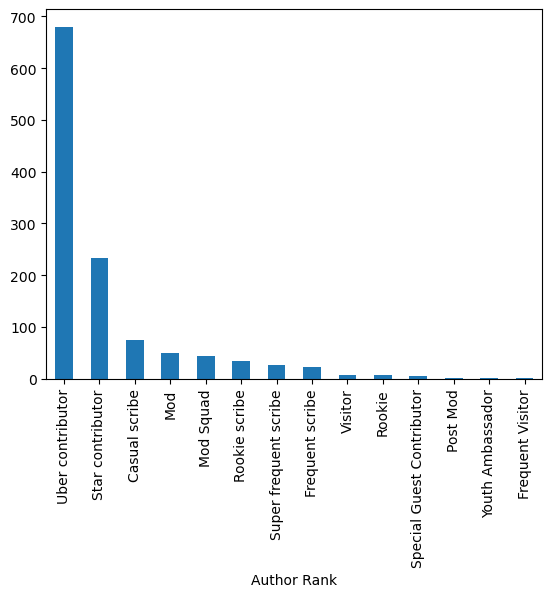

In [21]:
#Look at break-down of categories
df_new['Author Rank'].value_counts().plot(kind='bar')

In [22]:
#Look at records for those who work at ReachOut (Community Manager, Mod, Mod in Training, Mod Squad, Reachout.com Crew, Special Guest Contributor, Staff)
reachout_staff = ['Community Manager', 'Mod', 'Mod in Training', 'Mod Squad', 'Reachout.com Crew', 'Special Guest Contributor', 'Staff']
df_staff=df_new[df_new['Author Rank'].isin(reachout_staff)]
df_staff['Label'].value_counts()

Label
green    95
amber     2
Name: count, dtype: int64

In [23]:
pd.set_option('display.max_colwidth', None)
df_staff[df_staff['Label']=='amber']['Message Body']

601     Hey guys,<BR /><BR />Long time no see. <img class="emoticon emoticon-smileytongue" id="smileytongue" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-tongue.png" alt="Smiley Tongue" title="Smiley Tongue" /> Been busy with Assignments and have been binging on Netflix and thinking a lot about what both my psychologist and Dr said.<BR /><BR />They pretty much hate all these new fandangle terms for sexuality and pretty much don't believe in the term demi. They think I am romantically and sexually repressed. But I've had relationships and crushes since the incident they are referring to. So confused. Especially when it came from someone I trust. Not at all what I was expecting.<BR /><BR />Just got to remember that only I can define my sexuality.
1025                                                                                                                                                                                                                                     

In [24]:
df_staff[df_staff['Label']=='amber']['Author Rank']

601     Mod
1025    Mod
Name: Author Rank, dtype: object

In [25]:
#Use this code if we want to remove ReachOut.com staff
#test_df = df_new[~df_new['Author Rank'].isin(reachout_staff)]
#test_df['Author Rank'].value_counts()

### 2.2 Isolate Emojis
In this section, I pull out the emoji information from the message body so it can be included as a feature. I intend to remove the HTML tags from the message body, but this also removes the emoji information. I wanted to keep that information because I think it could speak to emotional distress or stability. I didn't just keep the description of the emoji but also the prefix text **"emoticon-"** so that the model would treat this as emoji information.

In [26]:
#Isolate emoji text
#Find the position of <img
df_new['pos_emoji'] = df_new['Message Body'].str.find('<img')

#Use position to slice using a lambda function, this is the portion of the emoji line I am interested in
#Originally had x['pos_emoji'] thru the end of the line to confirm that there was no additiona information needed
df_new['emoji_text_full'] = df_new.apply(lambda x: x['Message Body'][x['pos_emoji']+20:x['pos_emoji']+50], axis=1)

#Find the end of the emoji string
df_new['end_pos_emoji'] =  df_new['emoji_text_full'].str.find('"')

#Slice and cut-off remaining emoji text
df_new['emoji_text'] = df_new.apply(lambda x: x['emoji_text_full'][0:x['end_pos_emoji']], axis=1)

#Look at the distribution of emojis in training data
emoji_data=df_new[df_new['pos_emoji']>0]

In [27]:
#Remove emoji text if no emojis were used in the message
df_new['Emoji Text'] = df_new.apply(lambda x: x['emoji_text'] if x['pos_emoji']>=0 else '', axis=1)

In [28]:
df_new['Emoji Text'].value_counts()

Emoji Text
                               915
 emoticon-smileyhappy          138
 emoticon-smileysad             41
 emoticon-smileyvery-happy      34
 emoticon-smileytongue          31
 emoticon-smileywink             6
 emoticon-heart                  5
 emoticon-smileysurprised        4
 emoticon-cathappy               2
 emoticon-smileyfrustrated       2
 emoticon-smileyindifferent      2
 emoticon-manmad                 1
 emoticon-manfrustrated          1
 emoticon-manvery-happy          1
 emoticon-womanlol               1
 emoticon-smileymad              1
 emoticon-cattongue              1
 emoticon-catsad                 1
 emoticon-catvery-happy          1
Name: count, dtype: int64

<Axes: xlabel='Emoji Text'>

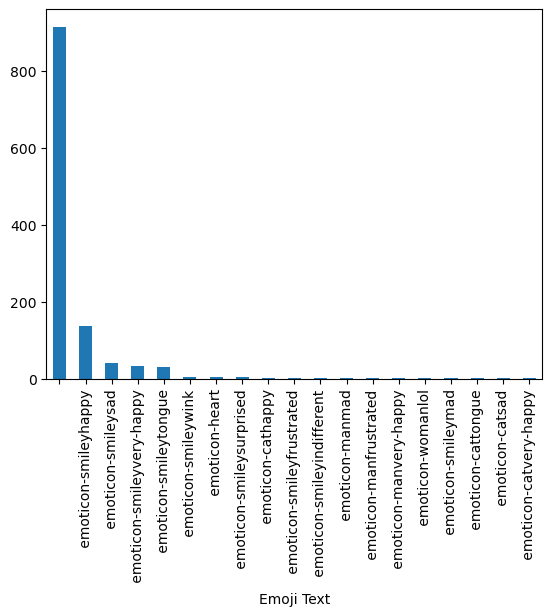

In [29]:
df_new['Emoji Text'].value_counts().plot(kind='bar')

### 2.3 Add Date and Time Features
In this section, I use the date/time that the post was made to derive features that I think may be important:

- **Hour**: The hour that the post was made. Studies show that suicides are more prevelant between midnight and 6 am.
- **Day of Week**: The day of the week that the post was made. Studies show that suicides are more likely to occurr on Sundays and Mondays.
- **Month**: The month that the post was made. I have not researched this, but imagine that suicides may be higher around the holidays

In [30]:
#Create date and time variables to be added as features
import datetime
import calendar

# datetime in string format for may 25 1999
input = '2021/05/25'
format = '%Y/%m/%d'
 
#Get message date and time as separate variables
df_new['pos_time'] = df_new['Message Post Time'].str.find('T')
df_new['pos_plus'] = df_new['Message Post Time'].str.find('+')

#Use position to slice and get date only
df_new['Date'] = df_new.apply(lambda x: x['Message Post Time'][0:x['pos_time']], axis=1)

df_new['Time'] = df_new.apply(lambda x: x['Message Post Time'][x['pos_time']+1:x['pos_plus']], axis=1)
df_new['Hour'] = df_new.apply(lambda x: x['Time'][0:2], axis=1)

# convert from string format to datetime format
df_new['Datetime'] = pd.to_datetime(df_new['Date'], format='%Y-%m-%d')
df_new['Month'] = df_new.apply(lambda x: x['Datetime'].strftime("%B"), axis=1)

#Monday=0, Sunday=6
df_new['Day of Week'] = df_new['Datetime'].dt.dayofweek

#Replace the numeric day of the week with the name of the day
daynames = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_new['Day of Week'].replace(daynames, inplace=True)

#Look at results to confirm accuracy
print(df_new[['Message Post Time', 'Datetime', 'Date', 'Time','Hour','Day of Week','Month']].head(3))

#Look at times
#df_new['what_time'] = df_new['Message Post Time'].str.find('T2')
#df_new[df_new['what_time']>0]

           Message Post Time   Datetime        Date      Time Hour  \
0  2015-04-24T03:49:50+00:00 2015-04-24  2015-04-24  03:49:50   03   
1  2015-04-24T04:01:22+00:00 2015-04-24  2015-04-24  04:01:22   04   
2  2015-04-24T04:43:34+00:00 2015-04-24  2015-04-24  04:43:34   04   

  Day of Week  Month  
0      Friday  April  
1      Friday  April  
2      Friday  April  


### 2.4 Remove HTML Tags from Text
In this section, I remove HTML tags from the text to make it more readable. I have also retained the raw text as I intend to compare the performance of my LLMs on text with and without HTML tags.

In [31]:
#Drop variables used for derivations and only keep variables of interest
df_red=df_new[['Message ID2', 'Author ID2', 'Label', 'Author Rank', 'Message Body', 'Emoji Text', 'Day of Week', 'Hour', 'Date', 'Datetime', 'Month', 'Time', 'Message Views', 'Message Kudos']]
df_red.tail((2))

,Message ID2,Author ID2,Label,Author Rank,Message Body,Emoji Text,Day of Week,Hour,Date,Datetime,Month,Time,Message Views,Message Kudos
1186,139565,5155,green,Uber contributor,"Looking forward to seeing my aunt tomorrow who I haven't seen in years, she is coming to Tassie for work and taking me out for dinner. Should be great.",,Sunday,12,2015-06-07,2015-06-07,June,12:16:09,214,2
1187,139568,5111,green,Uber contributor,Just keeping going minute by minute j,,Sunday,12,2015-06-07,2015-06-07,June,12:46:45,144,0


In [32]:
#Add variable for text without HTML tags
#df_new2=df_new.replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red['Message Body no HTML']=df_red['Message Body'].replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red.head((2))

,Message ID2,Author ID2,Label,Author Rank,Message Body,Emoji Text,Day of Week,Hour,Date,Datetime,Month,Time,Message Views,Message Kudos,Message Body no HTML
0,135267,5111,green,Uber contributor,<P>JAN<BR /> <BR />FEB<BR /> <BR />MAR<BR /> <BR />APR</P>\n<P>17th: - J95!&nbsp;<BR /> <BR />MAY<BR /> <BR />JUN<BR /> <BR />JUL<BR />19th: Sophie!!<BR /> <BR />AUG<BR /> <BR />SEP<BR /> <BR />OCT<BR /> <BR />NOV <BR /> <BR />DEC</P>,,Friday,03,2015-04-24,2015-04-24,April,03:49:50,519,0,JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV DEC
1,135268,5111,green,Uber contributor,"<P><div class=""video-embed-center video-embed-youtube""><iframe src=""http://www.youtube.com/embed/K_EjSuYWzxA"" width=""320"" height=""265"" frameborder=""0"" allowfullscreen=""true""></iframe></div></P>\n<P>&nbsp;</P>\n<P>Big Scary - Luck Now.&nbsp;</P>",,Friday,04,2015-04-24,2015-04-24,April,04:01:22,207,0,Big Scary - Luck Now.


In [33]:
#Look at two observations to compare how the text with and without HTML tags looks
pd.set_option('display.max_colwidth', None)
df_red[df_red['Message ID2']==135284]['Message Body']

7    Redhead: aaaaarrrrgggg getting really sick of this hypomania. When will this end. getting so agitated, bored. And its raining so I can't even get out for a walk to calm down. what to do. Its starting to make me feel unsafe...<img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /> sorry for being so negative again
Name: Message Body, dtype: object

In [34]:
df_red[df_red['Message ID2']==135284]['Message Body no HTML']

7    Redhead: aaaaarrrrgggg getting really sick of this hypomania. When will this end. getting so agitated, bored. And its raining so I can't even get out for a walk to calm down. what to do. Its starting to make me feel unsafe... sorry for being so negative again
Name: Message Body no HTML, dtype: object

In [35]:
df_red[df_red['Message ID2']==135284]['Emoji Text']

7     emoticon-smileysad
Name: Emoji Text, dtype: object

### 2.5 Map Labels to Numeric Values
Some of the LLMs I intend to use need categories in numbers instead of text, so I create a new variable (Label Num) to contain this information.

In [36]:
#Map the label to a numerical value because this is needed for BERT instead of the text
#to_rep = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
to_num = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
df_red['Label Num']=df_red['Label']
df_red.replace({'Label Num': to_num}, inplace=True)

### 2.6 Create Text + Features Variable
The research I did indicated that prepending the additional features as text to the message body could improve the accuracy of my LLM. I added the following information to the beginning of the message text:

- **Author Rank**: "My author rank is XXXXX."
- **Day**: "It is XXXXX."
- **Month**: "The month is XXXXX."
- **Emoji Text**: "emoticon-XXXXXXXX."
- **Views**: "This post has XXXX views."
- **Kudos**: "This post has XXXX kudos."

In [37]:
#Combine text and features
df_red['Text and Features'] = "My author rank is " + df_red['Author Rank'] + "." \
                            + " I posted this on " + df_red['Day of Week'] +"." \
                            + " The time is " + df_red['Hour'] + " oclock." \
                            + " The month is " + df_red['Month'] + ". " \
                            + df_red['Emoji Text'] \
                            + " This post has " + df_red['Message Views'] + " views." \
                            + " This post has " + df_red['Message Kudos'] + " kudos." \
                            + df_red['Message Body no HTML']
print(df_red[['Author Rank', 'Day of Week', 'Hour', 'Month','Message Views','Message Kudos','Message Body no HTML', 'Text and Features']].head(1))

        Author Rank Day of Week Hour  Month Message Views Message Kudos  \
0  Uber contributor      Friday   03  April           519             0   

                                                         Message Body no HTML  \
0  JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV  DEC   

                                                                                                                                                                                                                    Text and Features  
0  My author rank is Uber contributor. I posted this on Friday. The time is 03 oclock. The month is April.  This post has 519 views. This post has 0 kudos.JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV  DEC  


### 2.7 Split into Train and Validation
I used a 90-10 split for training and validation data. For the CLPsych project, they provided a separate testing dataset. I intend to use their "Training" data as training and validation and then apply my final model to their "Testing" data. However, the code does refer to the validaiton dataset as "test" since I used code from previous homeworks and this is what I had called the validation dataset.

After all my model tweaking and testing, I will apply the best LLM to the true testing dataset and check its accuracy.

In [38]:
#Separate data into test/train
np.random.seed(42)
test = df_red.sample(frac=0.1)
train = df_red[~df_red.index.isin(test.index)]

## 3 Baseline Classifiers
In this section, I explore baseline classifiers which I will compare my classifiers against: Random, Majority, and XGBoost classifiers.

### 3.1 Random Classifier
In this section, I test the accuarcy of a random classifier which assigns posts randomly to 1 of the 4 triage categories.

In [40]:
from sklearn.metrics import f1_score

type_list=['green','amber','red','crisis']
test['Random_BL'] = np.random.choice(type_list, len(test))
print("Accuracy: ", accuracy_score(test['Label'], test['Random_BL']))
print("F1: ", f1_score(test['Label'], test['Random_BL'], average='weighted'))

Accuracy:  0.21008403361344538
F1:  0.2665320909522884


### 3.2 Majority Classifier
In this section, I derive the majority classifier.

In [41]:
df_red['Label'].value_counts()

Label
green     715
amber     296
red       137
crisis     40
Name: count, dtype: int64

<Axes: xlabel='Label'>

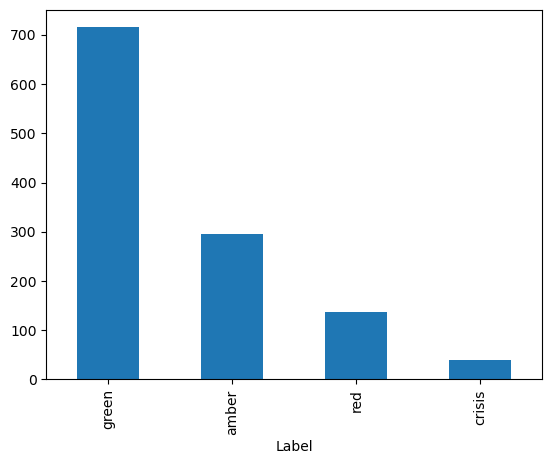

In [42]:
#Look at break-down of categories
df_red['Label'].value_counts().plot(kind='bar')

In [43]:
test['Majority_BL']='green'
print("Accuracy: ", accuracy_score(test['Label'], test['Majority_BL']))
print("F1: ", f1_score(test['Label'], test['Majority_BL'], average='weighted'))

Accuracy:  0.6554621848739496
F1:  0.5190461971590666


### 3.3 XGBoost Classifier
In this section, I create a classification tree using XGBoost and the non-text features of the data. I then plot the feature importance and gain to see which are most important for predicting triage label. Message Views appears to be the most important features, but the most gain comes from the Message Kudos variable.

In [44]:
#XGBoost with the categorical non-text variables: Author Rank, Day, Month, Hour
df_XG=df_red

#Assign code to each unique category value
df_XG["Author Rank"] = df_XG["Author Rank"].astype('category')
df_XG["Day of Week"] = df_XG["Day of Week"].astype('category')
df_XG["Month"] = df_XG["Month"].astype('category')

#Replace strings with coded values
df_XG["Author Rank"] = df_XG["Author Rank"].cat.codes
df_XG["Day of Week"] = df_XG["Day of Week"].cat.codes
df_XG["Month"] = df_XG["Month"].cat.codes

In [45]:
#Convert numerical fields to float
df_XG["Hour"] = df_XG["Hour"].astype('float')
df_XG['Message Views'] = df_XG['Message Views'].astype('float')
df_XG['Message Kudos'] = df_XG['Message Kudos'].astype('float')

In [46]:
import random
import numpy as np
np.random.seed(42)

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.9 * len(df_XG))
val_size = int(0.1 * len(df_XG))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(df_XG))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 
print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))

  Training size: 1,069
Validation size: 118


In [47]:
# Retrieve the labels for each of the splits.
y_train = df_XG["Label Num"].iloc[train_idx]
y_val = df_XG["Label Num"].iloc[val_idx]
#y_test = df_XG["Label Num"].iloc[test_idx]

# Before selecting the inputs, remove text columns and the labels.
df_XG= df_XG[['Author Rank','Day of Week','Month','Hour','Message Kudos', 'Message Views']]

# Select the inputs for the different splits.
X_train = df_XG.iloc[train_idx]
X_val = df_XG.iloc[val_idx]

In [48]:
from xgboost import XGBClassifier

# Create an instance of the classifier
model = XGBClassifier()

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_val)

# Calculate the accuracy.
print('Using XGBoost on non-text features')
print("Accuracy: ", accuracy_score(y_val, predictions))
print("F1: ", f1_score(y_val, predictions, average='weighted'))

Using XGBoost on non-text features
Accuracy:  0.5338983050847458
F1:  0.48257410308756266


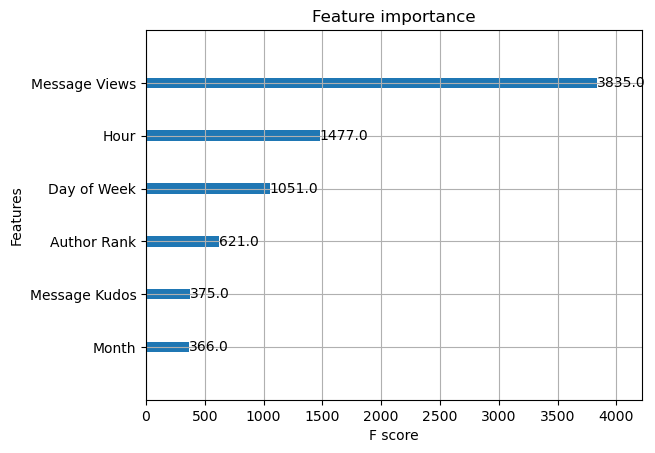

In [49]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Author Rank'),
  Text(1, 0, 'Day of Week'),
  Text(2, 0, 'Month'),
  Text(3, 0, 'Hour'),
  Text(4, 0, 'Message Kudos'),
  Text(5, 0, 'Message Views')])

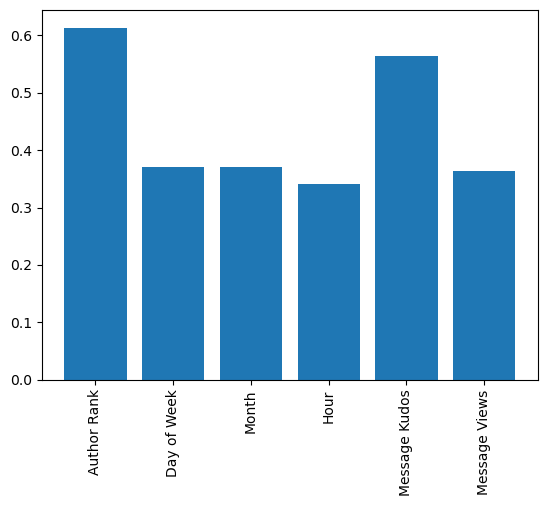

In [50]:
feat_gains = model.get_booster().get_score(importance_type="gain")

pyplot.bar(feat_gains.keys(), feat_gains.values())
pyplot.xticks(rotation = 90)

## 4 BERT Classifier

In [51]:
#Get length of longest message text (1,310 words)
# initialize list 
message = df_red['Message Body no HTML'].to_list()
  
# Longest String in list
# using max() + key
res = max(message, key = len)
 
# printing result
print("Maximum length string is : " + res)

Maximum length string is : Continuing... (because I went over the character limit... whoops)Neg:Rightio, that other negative. Around birthdays and christmas time gift giving seems like a natural part of the season. Which is why I don't feel as much guilt when given gifts but it's still there hanging over my shoulder, dragging me down. Because so often my family doesn't get it right and the gifts, they remain unused. A waste of money, just sitting there. Sometimes handed down but otherwise just wasted. And I feel at fault because they were for me, I should be thankful that I'm even receiving anything but all I feel is guilt and annoyance because my family just doesn't get me. I feel jealous of my younger cousin and brother who get cool things, things I would like, and I get the things my other cousin or sister would like. It's not right, socially, to be feeling jealous, guilt and annoyance in a 'jolly' season where I should be grateful, happy and... sombre? Humble even? And the worst pa

In [52]:
#Get the average number of words in a post
total_avg = sum( map(len, message) ) / len(message)
total_avg

400.57828282828285

In [53]:
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'
print(torch.version.cuda)

device

12.1


'cuda'

### 4.1 Raw Message Text

In [54]:
#Split test and training data into X and Y
train_X = train['Message Body'].to_list()
train_y = train['Label Num'].to_list()
test_X = test['Message Body'].to_list()
test_y = test['Label Num'].to_list()

len(train_X), len(train_y)

(1069, 1069)

In [55]:
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [56]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [57]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
print(train_X[10])

tokenizer.encode_plus(
            train_X[10],
            None,
            add_special_tokens=True,
            max_length=512,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

<P>@blithe&nbsp;</P>
<P>&nbsp;</P>
<P><STRONG>Thank you for your awesome advice - I feel much better. I had one of those mood swings where you feel like nothing can be achieved and all the self esteem drops and stuff. I am over it - I felt like I overreacted but I guess it got to do with the mood. Thank you for your suggestions and advice, the websites were useful, thank you. <img class="emoticon emoticon-smileyhappy" id="smileyhappy" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png" alt="Smiley Happy" title="Smiley Happy" /></STRONG></P>


{'input_ids': [101, 1026, 1052, 1028, 1030, 1038, 15909, 5369, 1004, 1050, 5910, 2361, 1025, 1026, 1013, 1052, 1028, 1026, 1052, 1028, 1004, 1050, 5910, 2361, 1025, 1026, 1013, 1052, 1028, 1026, 1052, 1028, 1026, 2844, 1028, 4067, 2017, 2005, 2115, 12476, 6040, 1011, 1045, 2514, 2172, 2488, 1012, 1045, 2018, 2028, 1997, 2216, 6888, 18755, 2073, 2017, 2514, 2066, 2498, 2064, 2022, 4719, 1998, 2035, 1996, 2969, 19593, 9010, 1998, 4933, 1012, 1045, 2572, 2058, 2009, 1011, 1045, 2371, 2066, 1045, 2058, 16416, 10985, 2021, 1045, 3984, 2009, 2288, 2000, 2079, 2007, 1996, 6888, 1012, 4067, 2017, 2005, 2115, 15690, 1998, 6040, 1010, 1996, 11744, 2020, 6179, 1010, 4067, 2017, 1012, 1026, 10047, 2290, 2465, 1027, 1000, 7861, 20214, 2239, 7861, 20214, 2239, 1011, 27420, 3270, 27659, 1000, 8909, 1027, 1000, 27420, 3270, 27659, 1000, 5034, 2278, 1027, 1000, 8299, 1024, 1013, 1013, 18708, 1012, 1045, 1012, 22157, 1012, 4012, 1013, 1045, 1013, 15488, 18622, 2229, 1013, 2385, 2595, 16048, 1035, 27420,

In [59]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # 7 classifications
LEARNING_RATE = 2e-05

train_y2 = torch.tensor(train_y, dtype=torch.long, device=device)
test_y2 = torch.tensor(test_y, dtype=torch.long, device=device)

training_data = MultiLabelDataset(train_X, train_y2, tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, test_y2, tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

In [60]:
#Run on Body with HTML codes
model = BERTClass(NUM_OUT)
model.to(device)   

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
 
    guesses = torch.max(guess, dim=1)    
    
    print('Acurracy on test set {}'.format(accuracy_score(guesses.indices.cpu().numpy(), targs.cpu().numpy())))
    print('F1 on test set {}'.format(f1_score(guesses.indices.cpu().numpy(), targs.cpu().numpy(), average='weighted')))

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.2081209421157837


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.1999701261520386


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.680672268907563
F1 on test set 0.732430705424207


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  1.023274302482605


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6974789915966386
F1 on test set 0.7326404245908891


### 4.2 Message Text without HTML Codes

In [105]:
#Separate data into test/train
np.random.seed(42)
test = df_red.sample(frac=0.1)
train = df_red[~df_red.index.isin(test.index)]

In [106]:
#Split test and training data into X and Y
train_X = train['Message Body no HTML'].to_list()
train_y = train['Label Num'].to_list()
test_X = test['Message Body no HTML'].to_list()
test_y = test['Label Num'].to_list()

len(train_X), len(train_y)

(1069, 1069)

In [107]:
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [108]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [109]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [111]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
print(train_X[5])

tokenizer.encode_plus(
            train_X[5],
            None,
            add_special_tokens=True,
            max_length=30,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

@Sophie-RO I need to say something but I dont know how


{'input_ids': [101, 1030, 8234, 1011, 20996, 1045, 2342, 2000, 2360, 2242, 2021, 1045, 2123, 2102, 2113, 2129, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [112]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # 7 classifications
LEARNING_RATE = 2e-05

train_y2 = torch.tensor(train_y, dtype=torch.long, device=device)
test_y2 = torch.tensor(test_y, dtype=torch.long, device=device)

training_data = MultiLabelDataset(train_X, train_y2, tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, test_y2, tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

In [113]:
#Run on Body without HTML codes
model = BERTClass(NUM_OUT)
model.to(device)   

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
 
    guesses = torch.max(guess, dim=1)    
    
    print('Acurracy on test set {}'.format(accuracy_score(guesses.indices.cpu().numpy(), targs.cpu().numpy())))
    print('F1 on test set {}'.format(f1_score(guesses.indices.cpu().numpy(), targs.cpu().numpy(), average='weighted')))

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.1568504571914673


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.1732046604156494


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.680672268907563
F1 on test set 0.7106399482870072


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.8439045548439026


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.7058823529411765
F1 on test set 0.7557457765714982


### 4.3 Message Text without HTML Codes + Features

In [114]:
#Separate data into test/train
np.random.seed(42)
test = df_red.sample(frac=0.1)
train = df_red[~df_red.index.isin(test.index)]

In [115]:
#Split test and training data into X and Y
train_X = train['Text and Features'].to_list()
train_y = train['Label Num'].to_list()
test_X = test['Text and Features'].to_list()
test_y = test['Label Num'].to_list()

len(train_X), len(train_y)

(1069, 1069)

In [116]:
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [117]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [118]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [119]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
print(train_X[5])

tokenizer.encode_plus(
            train_X[5],
            None,
            add_special_tokens=True,
            max_length=30,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

My author rank is Uber contributor. I posted this on Friday. The time is 05 oclock. The month is April.  This post has 215 views. This post has 0 kudos.@Sophie-RO I need to say something but I dont know how


{'input_ids': [101, 2026, 3166, 4635, 2003, 19169, 12130, 1012, 1045, 6866, 2023, 2006, 5958, 1012, 1996, 2051, 2003, 5709, 1051, 20464, 7432, 1012, 1996, 3204, 2003, 2258, 1012, 2023, 2695, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [120]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # 7 classifications
LEARNING_RATE = 2e-05

train_y2 = torch.tensor(train_y, dtype=torch.long, device=device)
test_y2 = torch.tensor(test_y, dtype=torch.long, device=device)

training_data = MultiLabelDataset(train_X, train_y2, tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, test_y2, tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

In [121]:
#Run on Text + Features
model = BERTClass(NUM_OUT)
model.to(device)   

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
 
    guesses = torch.max(guess, dim=1)    
    
    print('Acurracy on test set {}'.format(accuracy_score(guesses.indices.cpu().numpy(), targs.cpu().numpy())))
    print('F1 on test set {}'.format(f1_score(guesses.indices.cpu().numpy(), targs.cpu().numpy(), average='weighted')))

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.2050983905792236


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.0176002979278564


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6974789915966386
F1 on test set 0.7670510064490913


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  1.074723243713379


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6890756302521008
F1 on test set 0.7216247426122766


## 5. Testing Dataset

### 5.1 Import Testing Data

Since my final BERT model did not use any additional features and kept posts from all authors I only need to import message ID and the message body.

In [39]:
#Import all XML data which contains the text of the posts
from os import listdir, path
import xml.etree.ElementTree as ET
import re
import os
from lxml import etree

mypath = 'clpsych17-data/clpsych17-data/clpsych17-test/posts'
files = [path.join(mypath, f) for f in listdir(mypath) if f.endswith('.xml')]
messageIDs = []
messageBodys = []
messagePostTimes = []
authorIDs = []
kudos = []
views = []

#for file in files:
 #   print(file)
  #  tree = ET.parse(file)
   # root = tree.getroot()
    #for x in root[0]:
     #   print(x.tag, x.attrib)

for file in files:
    res = re.findall("post-(\d+).xml", file)
    if not res: continue
    messageIDs.append(res[0]) # You can append the result to a list
    tree = ET.parse(file)
    root = tree.getroot()
    for x in root[0]:
    #print(x.tag, x.attrib)
        if x.tag == 'body':
            messageBodys.append(x.text)
        if x.tag == 'post_time':
            messagePostTimes.append(x.text)
        if x.tag == 'author':
            authorIDs.append((x.attrib['href']).replace('/users/id/',''))
        if x.tag == 'kudos':
            kudos.append(x.findall(".//count")[0].text)
        if x.tag == 'views':
            views.append(x.findall(".//count")[0].text)
    if len(messageBodys) != len(messageIDs):
        messageBodys.append('')
    if len(messagePostTimes) != len(messageIDs):
        messagePostTimes.append('')
    if len(authorIDs) != len(messageIDs):
        authorIDs.append('')
    if len(kudos) != len(messageIDs):
        authorIDs.append('')
    if len(views) != len(messageIDs):
        authorIDs.append('')
    #print(res[0])


#tree.find('./message type').attrib['key']


In [44]:
#The import did not get authorIDs, views, or kudos imported properly
print(len(messageIDs))
print(len(authorIDs))
print(len(messageBodys))
print(len(views))
print(len(kudos))
print(len(messagePostTimes))

92206
358481
92206
81863
81863
92206


In [45]:
import pandas as pd
dict = {'Message ID': messageIDs, 'Message Body': messageBodys, 'Message Post Time': messagePostTimes} 
    
df = pd.DataFrame(dict)

In [46]:
df.tail()

,Message ID,Message Body,Message Post Time
92201,231770,"Hi <a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/292"">@lokifish</a><BR />Full of nightmares so didn't sleep that much.<BR />Yeah i find everything to be hard atm .",2017-03-10T02:03:50+00:00
92202,231771,"Everything <a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/8464"">@JanaG</a><BR />Im failing at my job. Im failing being a big sister. Im failing at studying. Im failing at making friends. Im failing at my family relationships. My mental health is shot as well as my physical<BR />Ive been promising to go for a bike ride with one sister and teach my youngest sister to ride a 2 wheeler bike but i haven't done either. Everyone keeps getting angry at me. I never do anything right. Im a horrible person!!",2017-03-10T02:17:35+00:00
92203,231772,"Hi, I don't know the answer to the question 'how many young people don't tell anyone about their mental illness' but in 2007 the Australian Bureau of Statistics conducted a survey that asked people who had mental disorder whether they had accessed a mental health service and only 23% of young people aged 16 -24 said they had. This means that 77% hadn't accessed a mental health service. Hope this helps. lorri-RO",2017-03-10T02:43:22+00:00
92204,231773,None,2017-03-10T02:50:40+00:00
92205,231774,"<P>How are you today&nbsp;<a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/5111"">@j95</a>? Hope you're feeling okay.</P><P>&nbsp;</P><P>Yay&nbsp;<a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/2306"">@N1ghtW1ng</a>! Good luck for the rest of your studying <img class=""emoticon emoticon-smileyhappy"" id=""smileyhappy"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png"" alt=""Smiley Happy"" title=""Smiley Happy"" /></P><P>&nbsp;</P><P><a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/9324"">@Paris83</a>&nbsp;Enjoy your tv watching <img class=""emoticon emoticon-smileyhappy"" id=""smileyhappy"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png"" alt=""Smiley Happy"" title=""Smiley Happy"" /> Reality tv is so much fun to watch sometimes&nbsp;<img class=""emoticon emoticon-smileytongue"" id=""smileytongue"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-tongue.png"" alt=""Smiley Tongue"" title=""Smiley Tongue"" /></P>",2017-03-10T03:24:54+00:00


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92206 entries, 0 to 92205
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Message ID         92206 non-null  object
 1   Message Body       89162 non-null  object
 2   Message Post Time  92206 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


In [66]:
#Bring in classification of message
df_label = pd.read_csv('clpsych17-data/clpsych17-data/clpsych17-test/2017-test.tsv', sep='\t', names=['Message ID2','Label','Detail Label','Empty1','Empty2'])

In [67]:
df_label.head()

,Message ID2,Label,Detail Label,Empty1,Empty2
0,194634,green,supporting,NaN,NaN
1,194658,green,allClear,NaN,NaN
2,194760,crisis,crisis,NaN,NaN
3,194783,green,allClear,NaN,NaN
4,194795,green,allClear,NaN,NaN


In [69]:
#Convert message ID and author to integer in order to merge with tab delimited files
df['Message ID2']=df['Message ID'].astype(int)

In [70]:
#Merge message text with classification
df_new=df.merge(df_label, how='inner', on='Message ID2')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Message ID         400 non-null    object 
 1   Message Body       400 non-null    object 
 2   Message Post Time  400 non-null    object 
 3   Message ID2        400 non-null    int32  
 4   Label              400 non-null    object 
 5   Detail Label       400 non-null    object 
 6   Empty1             0 non-null      float64
 7   Empty2             0 non-null      float64
dtypes: float64(2), int32(1), object(5)
memory usage: 23.6+ KB


In [74]:
#Check one record on the merge
df_new[df_new['Message ID2']==194760]

,Message ID,Message Body,Message Post Time,Message ID2,Label,Detail Label,Empty1,Empty2
2,194760,"<P>hello, I'm not really sure where to start with this or how to go about saying it I guess I've never really been good at telling people things but I thought I would give it a try. Over the last few year's I have been battling with anxiety and depression, up until the last few months I have been able to manage them on my own I have been able to manage the feelings they bring and all of the other bad stuff, but recently they have become too much for me to be able to handle and it is getting the better of me, the feelings of wanting to harm myself, of not enjoying life or the things in life, the feeling of everyone around me hating me, it is all becoming too much for me to handle. I am so stressed out with school and trying to be able to afford things like moving out of home at the end of the year and having a car, the stress of school mixed with doing nothing at school and people at school that is becoming too much to handle, I don't enjoy going to school or seeing my friends, when i get home things aren't much better I don't talk much to my family at all and I can't tell them things that are going on mentally with me because they have to deal with an older sibling of mine who for the last 8 years has been dealing with severe&nbsp;anxiety, depression, and self-harm and I just can't add my problems for my family to deal with, having someone so close to me as I have grown up going through this and seeing them hurt themselves and the other things have taken a seriously large toll on me. My girlfriend is also dealing with forms of depression and I can't really tell her things without the fear of her getting mad at me or upset at herself, I blame myself for her problems&nbsp;and I'm scared of the damage that her on a daily basis having to deal with me who is dealing with these illnesses I am scared of the damage it is doing to her, I blame myself for her self-harming I try to help her but I seem to just make things worse I feel like I'm a failure. I am always feeling sick due to stomach ulcers that have been caused from all the anxiety, due to these ulcers and the pain they cause me, I barely eat anything ever I have gone through periods where all I will eat is a very small dinner once a day. I don't sleep very well at night ever I only get a few hours of sleep mainly because I just can't fall asleep then when I do fall asleep I wake up many times, I feel useless in life like my life is going nowhere, I feel like I am fighting everything in my head on my own with nobody by my side to help me through it and it's not working anymore I'm not strong enough to keep going I'm becoming so tired&nbsp;(not sleeping tired but mentally tired) I can't keep my fight up much longer I am starting to break down in tears for no reason all the time, the urges to harm myself and to not keep fighting and just give up are just getting too strong. I feel that I am alone with all of this with nobody around to help I have nobody I can talk to,&nbsp;I'm struggling to cope with everything right now and I just can't take it my mind can't take it anymore. I'm sorry I'm an inconvenience to everyone and to the people around me, I'm sorry if this doesn't make much sense, I have never really been good at telling people things so I have just started writing and I'm&nbsp;sorry if this doesnt make sense, but long story short i really am struggling with everything at the moment and all i feel like doing is giving up and the stuff in my head is really starting to get to me and i can't find a way to escape from it.</P><P>Thank you for taking the time to read this, Jubby.&nbsp;</P>",2016-08-15T11:11:36+00:00,194760,crisis,crisis,NaN,NaN


In [75]:
#Drop variables used for derivations and only keep variables of interest
df_red=df_new[['Message ID2', 'Label','Message Body']]
df_red.tail((2))

,Message ID2,Label,Message Body
398,231256,red,"<P>i have allwas whated to have a cool good life but i stell dont. and i have got evryone telling me that wen i grow up</P><P>that im going to fael and that im not going to get eny wher and it suks. cuz my mum has mentil elnes to and i dont even now</P><P>wo my dad even is :,( I dont no what to do. plzzz help some one enyone</P><P>&nbsp;</P><P>(FYI) I SUKE AT ENGLESH and its hard geting throw life. and i dot even know what a good life is.</P><P>&nbsp;</P><P>&nbsp;</P><P>&nbsp;</P>"
399,231774,green,"<P>How are you today&nbsp;<a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/5111"">@j95</a>? Hope you're feeling okay.</P><P>&nbsp;</P><P>Yay&nbsp;<a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/2306"">@N1ghtW1ng</a>! Good luck for the rest of your studying <img class=""emoticon emoticon-smileyhappy"" id=""smileyhappy"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png"" alt=""Smiley Happy"" title=""Smiley Happy"" /></P><P>&nbsp;</P><P><a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/9324"">@Paris83</a>&nbsp;Enjoy your tv watching <img class=""emoticon emoticon-smileyhappy"" id=""smileyhappy"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png"" alt=""Smiley Happy"" title=""Smiley Happy"" /> Reality tv is so much fun to watch sometimes&nbsp;<img class=""emoticon emoticon-smileytongue"" id=""smileytongue"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-tongue.png"" alt=""Smiley Tongue"" title=""Smiley Tongue"" /></P>"


In [76]:
#Add variable for text without HTML tags
#df_new2=df_new.replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red['Message Body no HTML']=df_red['Message Body'].replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red.head((2))

,Message ID2,Label,Message Body,Message Body no HTML
0,194634,green,"Hey <a href=""http://forums.au.reachout.com/t5/user/viewprofilepage/user-id/8220"">@BluezCluez</a>,<BR /><BR />Before I say anything else, I want to let you know how awesome it is you went out. Living with social anxiety is hard, and going out can be really difficult. Even though it took a negative turn, you should still be super proud that you went out.<BR />It sucks that the old man was so rude to you, sometimes people can be so horrible, it's not right and it's okay to get mad. You handled yourself really well in that situation, you should be proud of that too. <img class=""emoticon emoticon-smileyhappy"" id=""smileyhappy"" src=""http://inspire.i.lithium.com/i/smilies/16x16_smiley-happy.png"" alt=""Smiley Happy"" title=""Smiley Happy"" /> It is really hard to not act on your anger and remaining in control is a good thing, even though the guy might've deserved it. Your parents are wrong in calling you a coward, it takes more strength to resist than to act.<BR /><BR />I don't know why people act the way they do, but not everyone is horrible. There are good people out there, and those people make it all worthwhile, as hard as they might be to find, they are there.<BR />I can't say for sure how I would've reacted in that situation. I do know that you did really well in how you reacted.<BR /><BR />How are you feeling today? Have things improved at all?","Hey @BluezCluez,Before I say anything else, I want to let you know how awesome it is you went out. Living with social anxiety is hard, and going out can be really difficult. Even though it took a negative turn, you should still be super proud that you went out.It sucks that the old man was so rude to you, sometimes people can be so horrible, it's not right and it's okay to get mad. You handled yourself really well in that situation, you should be proud of that too. It is really hard to not act on your anger and remaining in control is a good thing, even though the guy might've deserved it. Your parents are wrong in calling you a coward, it takes more strength to resist than to act.I don't know why people act the way they do, but not everyone is horrible. There are good people out there, and those people make it all worthwhile, as hard as they might be to find, they are there.I can't say for sure how I would've reacted in that situation. I do know that you did really well in how you reacted.How are you feeling today? Have things improved at all?"
1,194658,green,"<P>Hi awesome people!</P><P>&nbsp;</P><P><STRONG>Tell us a bit about your pets? If you don’t have pets, tell us what sort of pet you would like!</STRONG></P><P>I'm not allowed pets where I live (the joys of renting)&nbsp;</P><P>When I buy my own house (eventually) I'm gonna have a kitty, a dog and a pet sheep that I will train.&nbsp;</P>","Hi awesome people!Tell us a bit about your pets? If you don’t have pets, tell us what sort of pet you would like!I'm not allowed pets where I live (the joys of renting)When I buy my own house (eventually) I'm gonna have a kitty, a dog and a pet sheep that I will train."


In [77]:
#Map the label to a numerical value because this is needed for BERT instead of the text
#to_rep = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
to_num = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
df_red['Label Num']=df_red['Label']
df_red.replace({'Label Num': to_num}, inplace=True)

### 5.2 Run BERT Model on Testing

In [78]:
realtest=df_red

In [80]:
#Split test and training data into X and Y
train_X = train['Message Body no HTML'].to_list()
train_y = train['Label Num'].to_list()

test_X = test['Message Body no HTML'].to_list()
test_y = test['Label Num'].to_list()

realtest_X = realtest['Message Body no HTML'].to_list()
realtest_y = realtest['Label Num'].to_list()

len(train_X), len(train_y)

(1069, 1069)

In [81]:
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [82]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [83]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [84]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
print(train_X[5])

tokenizer.encode_plus(
            train_X[5],
            None,
            add_special_tokens=True,
            max_length=30,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

@Sophie-RO I need to say something but I dont know how


{'input_ids': [101, 1030, 8234, 1011, 20996, 1045, 2342, 2000, 2360, 2242, 2021, 1045, 2123, 2102, 2113, 2129, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [85]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # 7 classifications
LEARNING_RATE = 2e-05

train_y2 = torch.tensor(train_y, dtype=torch.long, device=device)
test_y2 = torch.tensor(test_y, dtype=torch.long, device=device)
realtest_y2 = torch.tensor(realtest_y, dtype=torch.long, device=device)

training_data = MultiLabelDataset(train_X, train_y2, tokenizer, MAX_LEN)
test_data     = MultiLabelDataset(test_X, test_y2, tokenizer, MAX_LEN)
realtest_data = MultiLabelDataset(realtest_X, realtest_y2, tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

realtest_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }  

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)
realtesting_loader = torch.utils.data.DataLoader(realtest_data, **realtest_params)

In [87]:
#Run on Body without HTML codes
from sklearn.metrics import f1_score

model = BERTClass(NUM_OUT)
model.to(device)   

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  

    #Validation Dataset
    guess, targs = validation(model, testing_loader)
 
    guesses = torch.max(guess, dim=1)    
    
    print('Acurracy on validation set {}'.format(accuracy_score(guesses.indices.cpu().numpy(), targs.cpu().numpy())))
    print('F1 on validation set {}'.format(f1_score(guesses.indices.cpu().numpy(), targs.cpu().numpy(), average='weighted')))

    #Testing Dataset
    realguess, realtargs = validation(model, realtesting_loader)
 
    realguesses = torch.max(realguess, dim=1)    
    
    print('Acurracy on test set {}'.format(accuracy_score(realguesses.indices.cpu().numpy(), realtargs.cpu().numpy())))
    print('F1 on test set {}'.format(f1_score(realguesses.indices.cpu().numpy(), realtargs.cpu().numpy(), average='weighted')))

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.1574394702911377


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on validation set 0.7058823529411765
F1 on validation set 0.7786189620356814


  0%|          | 0/7 [00:00<?, ?it/s]

Acurracy on test set 0.6125
F1 on test set 0.7104682899394581


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.973932147026062


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on validation set 0.7142857142857143
F1 on validation set 0.7694330209667632


  0%|          | 0/7 [00:00<?, ?it/s]

Acurracy on test set 0.6575
F1 on test set 0.7350908769031039


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.9791950583457947


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on validation set 0.7226890756302521
F1 on validation set 0.7680336355934863


  0%|          | 0/7 [00:00<?, ?it/s]

Acurracy on test set 0.67
F1 on test set 0.7399282420154185


In [98]:
test_result = pd.DataFrame({'Predicted': realguesses.indices.cpu().numpy(), 'Actual': realtargs.cpu().numpy()}, columns=['Predicted', 'Actual'])

In [100]:
predicted= realguesses.indices.cpu().numpy()

In [102]:
actual=realtargs.cpu().numpy()

In [109]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Green', 'Amber', 'Red', 'Crisis'])

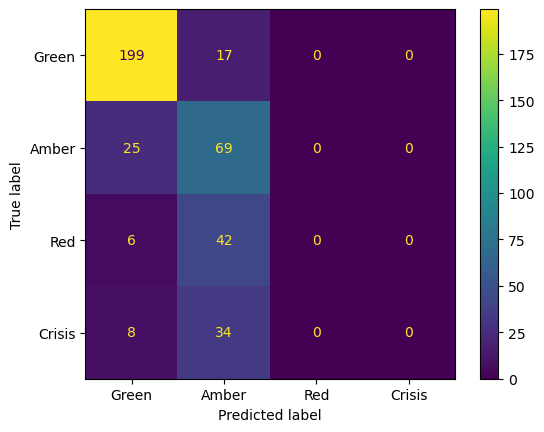

In [110]:
cm_display.plot()